In [1]:
import os,re
import time,pickle
from tqdm import *
from os.path import expanduser
import sklearn
import matplotlib.pylab as plt
%matplotlib inline

from gensim import corpora, models, similarities

# Introduction

The AGU conference is hold each year in San Francisco a few weeks before christmas.

With nearly 24,000 attendees, AGU Fall Meeting is the largest Earth and space science meeting in the world. As such, it is also a great dataset to study trends in the geoscience community. In the following, I use the papers contribution in the year 2015 and 2014 to find out some hidden structure in the abstracts.
The aim is two fold:

- For a given contribution, identify a list of similar contribution in the database
- For the contributions of a particular authors, identify a list of potential collaborators with names, adress and institute displayed on a map.

The method is greatly inspired from [Amir Amini](https://www.kaggle.com/amirhamini/d/benhamner/nips-2015-papers/find-similar-papers-knn/notebook) and [brandonmrose](http://brandonrose.org/clustering).

# Data preprocessing 

## Scrapping the AGU website 

The scripts used to scrap the [AGU wesbsite](https://fallmeeting.agu.org/2015/) as well as the resulting data are stored on this [repo](https://github.com/cthorey/agu_data) if you want to reproduce the following by yourself.

In [2]:
home = expanduser('~')
os.chdir(os.path.join(home,'Documents','project','agu_data','repo','agu_data'))
from Data_Utils import *

data = get_all_data('agu2015')
sources = [df for df in data if (''.join(df.title) != "") and (df.abstract != '')]
raw_abstracts = [df.abstract for df in sources]
raw_titles = [' '.join(df.title) for df in sources]
sessions = [f.session for f in sources]
sections = [f.section for f in sources]
authors = [', '.join(f.authors.keys()) for f in sources]

def first_clean_title(text):
    if text.split(' ')[-1] == '(Invited)':
        text = ' '.join(text.split(' ')[:-1])
    return text

def first_clean_abstract(text):
    if text.split('\n')[0].split(' ')[0] =='ePoster':
        text = ' '.join(text.split('\n')[1:])
    return text

raw_abstracts = map(first_clean_abstract,raw_abstracts)
raw_titles = map(first_clean_title,raw_titles)

AGU abstract are short, $\sim 300$ words and looks like that

In [3]:
idx = 300
print '\n The title of this paper is : \n %s'%(raw_titles[idx])
print '\n The corresponding abstract is :\n %s'%(raw_abstracts[idx])


 The title of this paper is : 
  Slow Climate Velocities in Mountain Streams Impart Thermal Resistance to Cold-Water Refugia Across the West

 The corresponding abstract is :
 Mountain streams provide important headwater refugia for native fish, amphibians, and other cold-water fauna globally. Although the well documented existence of such refugia indicates some level of resistance to ongoing environmental change, stream warming associated with climate change raises questions about their future persistence. Moreover, evidence exists that air temperatures are warming faster at higher elevations, and some stream temperature models predict that cold streams associated with snowmelt hydrologies will be most sensitive to air temperature increases (i.e. high ratio of stream Δ˚C:air Δ˚C). Here, we estimate stream sensitivities to climate forcing using long-term monitoring records from 927 sites across the topographically complex northwestern U.S. Sensitivity values are combined with high-res

We first remove extra text in the abstract (eposter) and (Invited) + convert unicode characters

In [4]:
import unicodedata

def clean(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii','ignore')
    text = text.replace('\n', ' ')
    return text

titles = map(clean,raw_titles)
abstracts = map(clean,raw_abstracts)

In [5]:
idx = 300
print '\n The title of this paper is : \n %s'%(titles[idx])
print '\n The corresponding abstract is :\n %s'%(abstracts[idx])


 The title of this paper is : 
  Slow Climate Velocities in Mountain Streams Impart Thermal Resistance to Cold-Water Refugia Across the West

 The corresponding abstract is :
 Mountain streams provide important headwater refugia for native fish, amphibians, and other cold-water fauna globally. Although the well documented existence of such refugia indicates some level of resistance to ongoing environmental change, stream warming associated with climate change raises questions about their future persistence. Moreover, evidence exists that air temperatures are warming faster at higher elevations, and some stream temperature models predict that cold streams associated with snowmelt hydrologies will be most sensitive to air temperature increases (i.e. high ratio of stream  C:air  C). Here, we estimate stream sensitivities to climate forcing using long-term monitoring records from 927 sites across the topographically complex northwestern U.S. Sensitivity values are combined with high-resol

## Tokenizing and stemming

The texts above cannot be fed directly into an algorithm to identify pattern within the corpus.
Instead, some form of vectorization have to be used.

A bag of words method is generally used in that purpose. In such a method, each document is first broken into unbreakable tokens and, in this method:

- each individual token occurrence frequency (normalized or not) is treated as a feature.
- the vector of all the token frequencies for a given document is considered a multivariate sample.

In the following, I build a function based on the library **nltk** to broke a documents into its most basic form, a list of stems.

To do so, 

- We first broke each documents in sentence and the words
- Remove all numeric, ponctuations with the module **re**
- Remove stowords from the tokens
- Stem each resulting tokens

In [7]:
import nltk

# Load SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token.lower())
    filtered_tokens = [token for token in filtered_tokens if token not in stopwords]
    stems = map(stemmer.stem,filtered_tokens)
    return map(str,stems)

# tf-idf representation 

Using the **tokenize_and_stem** function, we can then break each document in tokens and vectorize it. The vectorization will result in a matrix whom 

- each line is a text document of the corpus
- each column represent a token from the corpus
- a specific value represent the number of occurences of a particular token in a particular document

While **sklearn** provides a class **CountVectorizer** which can be used to form such a matrix, this representation often put to much weights on common words of the corpus, i.e. words like *the*, *a* in english. While this can be interesting in some situations, we would like to put more weight on words that make each abstract specific for our application.

One way to do this is to use a **Tf-idf** normalization to re-weiht each value in the matrix by the frequency of the token in the whole corpus. **Tf** means term-frequency while **tf–idf** means term-frequency times inverse document-frequency.

This normalization is implemented by the **TfidfTransformer** class of sklearn and is used in the following.

Main parameters:

- max_df : When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
- min_df : When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold
- ngram_range : Range of n-gram to consider. Bi-gram and Three gram like floor fractured craters is preserved

## Small sub-routine

In [8]:
# Small routine to save the idf class and the resulting matrix.
model_saved = os.path.join(home,'Documents','project','agu_data','repo','Notebook','Models')
from sklearn.externals import joblib
def save_idf(folder,idf_vectorizer,idf_matrix):
    joblib.dump(idf_vectorizer,os.path.join(folder,'idf_vectorizer.pkl'))
    joblib.dump(idf_matrix,os.path.join(folder,'idf_matrix.pkl'))
    
def open_idf(folder):
    idf_vectorizer = joblib.load(os.path.join(folder,'idf_vectorizer.pkl'))
    idf_matrix = joblib.load(os.path.join(folder,'idf_matrix.pkl'))
    return idf_vectorizer, idf_matrix

## Titles 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

folder_titles = os.path.join(model_saved,'tfidf','titles')
recompute = False
if len(os.listdir(folder_titles)) == 0 or recompute:
    print 'Create files'
    titles_tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',
                                   max_df=0.95, 
                                   max_features=200000, 
                                   min_df=0.001, 
                                   stop_words=stopwords,
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem,
                                   lowercase = True,
                                   ngram_range=(1,3))
    %time idf_titles = titles_tfidf_vectorizer.fit_transform(titles)
    save_idf(folder_titles,titles_tfidf_vectorizer,idf_titles)
else:
    print 'Load files'
    %time titles_tfidf_vectorizer, idf_titles = open_idf(folder_titles)

Load files
CPU times: user 1.92 s, sys: 96.2 ms, total: 2.02 s
Wall time: 2.28 s


## Abstracts 

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
folder_abstracts = os.path.join(model_saved,'tfidf','abstracts')

recompute = False
if len(os.listdir(folder_titles)) == 0 or recompute:
    print 'Create files'
    abstracts_tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',
                                   max_df=0.9, 
                                   max_features=200000, 
                                   min_df=0.01, 
                                   stop_words=stopwords,
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem,
                                   lowercase = True,
                                   ngram_range=(1,3))
    %time idf_abstracts = abstracts_tfidf_vectorizer.fit_transform(abstracts)
    save_idf(folder_abstracts,abstracts_tfidf_vectorizer,idf_abstracts)
else:
    print 'Load files'
    %time abstracts_tfidf_vectorizer, idf_abstracts = open_idf(folder_abstracts)

Load files
CPU times: user 29.7 s, sys: 2.78 s, total: 32.5 s
Wall time: 36 s


In [19]:
len(abstracts_tfidf_vectorizer.vocabulary_)

1922

## Making sense of the tf-idf resulting arrays 

In [10]:
import pandas as pd
import numpy as np

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return 
        them with their corresponding feature names.'''
    
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [11]:
idx = 6339
top_tfidf_feats(np.squeeze(idf_abstracts[idx].toarray()),abstracts_tfidf_vectorizer.get_feature_names(),5)

,feature,tfidf
0,intrus,0.595818
1,deform,0.223510
2,magmat,0.204524
3,regim,0.180677
4,predict,0.167379


In [12]:
idx = 6339
top_tfidf_feats(np.squeeze(idf_titles[idx].toarray()),titles_tfidf_vectorizer.get_feature_names(),5)

,feature,tfidf
0,general,0.538683
1,intrus,0.511470
2,magmat,0.465001
3,shallow,0.427042
4,model,0.222773


# Finding similar document based on the abstracts

## Cosine similarities 

The tf-idf representation provides a high-dimensionlal embedding of each paper in the corpus. From there, the baseline method is to use directly this representation to compute similiarites between different abstract. This is the so-called [Vector Space Model](https://en.wikipedia.org/wiki/Vector_space_model).

Indeed, in the tf-df representation, each paper represents a vector in a high dimensional space. The *distance* or the *similarity*, according to some metrics, can then be used to compare different contributions together. 

The euclidean distance is the more natural choise for the similarity measure. Given two vectors  $\vec{a}$ and $\vec{b}$, it is equal to 
$$d(\vec{a},\vec{b}) = \sqrt{(\vec{b}- \vec{a})\cdot(\vec{b}- \vec{a}) }$$


However, we'd like our distance to be independant of the magnitude of the difference between two vectors. For instance, we'd like to identify as similar two documents which contain exactly the same words even if the word occurences differ significantly. The euclidean distance clearly does not have this property.

Accordingly, a more reliable measure for our purpose is called "the cosine similarity". For two vectors, $\vec{a}$ and $\vec{b}$, the cosine similarity $d$ is defined as :

$$ d(\vec{a},\vec{b})= \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|} = \cos(\vec{a},\vec{b})$$

In particular, this similarity measure is the dot product of the two normalized vector and hence, depends only on the angle between the two vectors (which is were its name comes from ;).

The good thing with our tf-idf representation is that each row, i.e. each abstract, is already normalized. Therefore, computing the similarity between two abstracts can be done by a simple dot product between the two corresponding rows. 

In [10]:
def find_recommendation(vrepr,tfidf_matrix,top_n):
    ''' Return the similarity as well as the index of the top_n abstracts for one contribution
    
    Args:
        vrepr:  vector represenatation of the contribution you want to look at
        tfidf_matrix: tf-idf matrix for the corpus
        top_n: Number of similar contribution you want to retreive
    
    Returns:
        Similarity score and index of the top_n closest abstract
    '''
    score = np.squeeze(np.dot(tfidf_matrix.toarray(),vrepr.T))
    score_idx = np.argsort(score)[::-1]
    return score[score_idx[:top_n]],score_idx[:top_n]

Let's try our method on my AGU contribution this year.

In [11]:
def name_to_idx(name):
    ''' From an authors, return the list of contributions '''
    contrib = [f for f in sources if name in f.authors.keys()]
    return [sources.index(elt) for elt in contrib]
    
my_contrib = name_to_idx('Clement Thorey')

In [12]:
idf_matrix = idf_abstracts
vrepr = idf_matrix[my_contrib[1],:].toarray()
similarities, indexs = find_recommendation(vrepr, idf_matrix, 10)
recoms = np.array(sources)[indexs]
for i, elt in enumerate(recoms):
    print 'Rank %d contrib is: %s'%(i,elt.title[0])

NameError: name 'idf_abstracts' is not defined

Without getting into the details, this abstract was about the dynamics of magmatic intrusions, batches of magma that stall at shallow depth into the Earth crust. Look's like our vanilla algorithm makes a pretty good job! I have actually been to most of the 25 recommendations this year.

Instead of looking at a specific contribution, we can also just throw in some keywords. The only additional step in that case is to transform our request into the vector space before giving it to the **find_recommenation** function.

In [16]:
request = ['machine learning']
vrepr = abstracts_tfidf_vectorizer.transform(request).toarray()
idf_matrix = idf_abstracts
similarities, indexs = find_recommendation(vrepr, idf_matrix, 10)
recoms = np.array(sources)[indexs]
for i, elt in enumerate(recoms):
    print 'Rank %d contrib is: %s'%(i,elt.title[0])

Rank 0 contrib is:  Integrating Scientific Inquiry into an Undergraduate Applied Remote Sensing Course
Rank 1 contrib is:  The World Climate Exercise
Rank 2 contrib is:  Learning and Risk Exposure in a Changing Climate (Invited)
Rank 3 contrib is:  Online Experiential Learning
Rank 4 contrib is:  Blue Sky Funders Forum - Advancing Environmental Literacy through Funder Collaboration (Invited)
Rank 5 contrib is:  Promoting Physical Understanding through Peer Mentoring
Rank 6 contrib is:  Place in Pacific Islands Climate Education
Rank 7 contrib is:  Evolution of Evaluation and Assessment in Diverse Audiences in the Digital Age (Invited)
Rank 8 contrib is:  Field Learning as a powerful tool of Education for geoscience, environment and disaster prevention.
Rank 9 contrib is:  Harnessing the power of mobile technologies for collaborating, crowdsourcing, and creating (Invited)


This example is less convincing. The return proposition are actually focused on learning but none exhibit machine learning thematic as expected by the request. This is actually expected as these recommendation are based on the abstract itself. Machine learning keywords in geoscience conference like AGU are more likely to be diluted in the application itself within the abstract. We should have more luck on a title-based recommendation.

In [17]:
request = ['machine learning']
vrepr = titles_tfidf_vectorizer.transform(request).toarray()
idf_matrix = idf_titles
similarities, indexs = find_recommendation(vrepr, idf_matrix, 10)
recoms = np.array(sources)[indexs]
for i, elt in enumerate(recoms):
    print 'Rank %d contrib is: %s'%(i,elt.title[0])

Rank 0 contrib is:  Floor-Fractured Craters through Machine Learning Methods
Rank 1 contrib is:  Machine Learning for Flood Prediction in Google Earth Engine
Rank 2 contrib is:  Machine Learning in Ionospheric Phenomena Detection Using Passive Radar
Rank 3 contrib is:  CME Prediction Using SDO, SoHO, and STEREO data with a Machine Learning Algorithm
Rank 4 contrib is:  A Data-Driven Approach to Assess Coastal Vulnerability
Rank 5 contrib is:  Near-Surface Crevasse Detection in Ice Sheets using Feature-Based Machine Learning
Rank 6 contrib is:  Applying Machine Learning Tools to the Identification of Foreshock Transient Events
Rank 7 contrib is:  Machine Learning to Assess Grassland Productivity in Southeastern Arizona
Rank 8 contrib is:  Temporal Mixture Analysis of Hypertemporal Antarctic Sea Ice Data in the Sense of Machine Learning
Rank 9 contrib is:  Using Machine learning method to estimate Air Temperature from MODIS over Berlin


And here they are ;)

## Difference between the abstract based and the titles based recommendations 

What about the contribution-recommendations based on the titles only ?

In [18]:
idf_matrix = idf_titles
vrepr = idf_matrix[my_contrib[1],:].toarray()
similarities, indexs = find_recommendation(vrepr, idf_matrix, 10)
recoms = np.array(sources)[indexs]
for i, elt in enumerate(recoms):
    print 'Rank %d contrib is: %s'%(i,elt.title[0])

Rank 0 contrib is:  A General Model for Shallow Magmatic Intrusions
Rank 1 contrib is:  A generalized quasi-geostrophic model of thermal convection (Invited)
Rank 2 contrib is:  Characteristics of Earthquakes Induced by Shallow and Deep Crustal Dike Intrusions
Rank 3 contrib is:  Modeling of Magnetic Anomalies Associated with Magmatic Intrusions Away from the Guaymas Basin Rift, Gulf of California
Rank 4 contrib is:  Periodicity of Kı̄lauea’s Dike Intrusions
Rank 5 contrib is:  How to build a mid-crustal intrusive suite
Rank 6 contrib is:  Petrological evidence for non-linear increase of magmatic intrusion rates before eruption at open vent mafic volcanoe
Rank 7 contrib is:  Interactive Modelling of Salinity Intrusion in the Rhine-Meuse Delta
Rank 8 contrib is:  Modeling Saltwater Intrusion in Highly Heterogeneous Coastal Aquifers
Rank 9 contrib is:  Yingmailai Granitic Intrusion in the Southern Tianshan：Magnetite-series or Ilmenite-series?


As expected, the recommendations is not exactly the same. Indeed, the information retrieval from only the tile is a more random task than based on the larger abstract content. Based-title recommendantion highly depends on the title content. 

For instance, my second contribution to AGU was about the detection of floor-fractured craters through machine learning method. While the abstract of this contribution is more planetology (cratering stuff) related, I wanted *machine learning* to appear in the title for encouraging people in the machine learning community to stop by and talk about the algorithm I used.


In [19]:
idf_matrix = idf_titles
vrepr = idf_matrix[my_contrib[0],:].toarray()
similarities, indexs = find_recommendation(vrepr, idf_matrix, 10)
recoms = np.array(sources)[indexs]
print 'Recommendantion tittle-based'
for i, elt in enumerate(recoms):
    print 'Rank %d contrib is: %s'%(i,elt.title[0])
    
idf_matrix = idf_abstracts
vrepr = idf_matrix[my_contrib[0],:].toarray()
similarities, indexs = find_recommendation(vrepr, idf_matrix, 10)
recoms = np.array(sources)[indexs]
print '\n\nRecommendantion abstract-based'
for i, elt in enumerate(recoms):
    print 'Rank %d contrib is: %s'%(i,elt.title[0])

Recommendantion tittle-based
Rank 0 contrib is:  Floor-Fractured Craters through Machine Learning Methods
Rank 1 contrib is:  Using Machine learning method to estimate Air Temperature from MODIS over Berlin
Rank 2 contrib is:  Machine Learning for Flood Prediction in Google Earth Engine
Rank 3 contrib is:  Machine Learning in Ionospheric Phenomena Detection Using Passive Radar
Rank 4 contrib is:  CME Prediction Using SDO, SoHO, and STEREO data with a Machine Learning Algorithm
Rank 5 contrib is:  A Data-Driven Approach to Assess Coastal Vulnerability
Rank 6 contrib is:  Near-Surface Crevasse Detection in Ice Sheets using Feature-Based Machine Learning
Rank 7 contrib is:  Applying Machine Learning Tools to the Identification of Foreshock Transient Events
Rank 8 contrib is:  Machine Learning to Assess Grassland Productivity in Southeastern Arizona
Rank 9 contrib is:  Temporal Mixture Analysis of Hypertemporal Antarctic Sea Ice Data in the Sense of Machine Learning


Recommendantion abstr

As expected, the recommendations favor machine learning abstract based on the title only and planetology related topics when looking at the abstract. While it could be possible to combine both approach, I found the results complementary and decided not to go further at this point.

## **Sklearn** implementation

**Sklearn** actaully implemented a class NearestNeighboor which ingest the tf-idf based matrix and is able to return the closest neightboor according to a whole bunch of difference distance metrics. While, our function designed above looks pretty fast, I assumed their implementation is more complete and I'll use it in the following.

In [20]:
from sklearn.neighbors import NearestNeighbors

def print_result(recom, verbose):
    ''' Detail printing of the recommendation 
    
    Args:
        recom : Dataframe of the recommendation
        verbose: Degree of verbosity
            - 0: no printing
            - 1: print the titles
            - >1: print the authors and the abstracts
            - >2: print more than 2 recommendations
    '''
    for i, row in recom.iterrows():
        if verbose <3:
            if i>2:
                break
        if i == 0:
            if verbose>0:
                print 'The recommendation is based on the contribution: %s \n'%(row.title)
            if verbose >1:
                print 'of %s\n'%(row.authors)
                print 'The abstract is: \n \n%s \n\n'%(row.abstract)
        else:
            if verbose >0:
                print 'The recommendation number %d is: %s\n'%(i,row.title)
            if verbose >1:
                print 'of %s\n'%(row.authors)
                print 'The abstract is: \n \n%s \n\n'%(row.abstract)
        

def idx_to_recom(index, n_neightboor = 20, based_on ='abstracts', verbose = 0):
    ''' Return a list of recommendation for the corresponding index
    
    Args:
        index : index of the contribution to look at
        n_neightboor : Number of neightboor to return
        based_on : Base the recommendation on the abstract or the titles ?
        verbose : Degree of verbosity for the return
        
    Returns:
        A size n_neightboor dataframe of the recommendation
        
    '''
    base = {'abstracts': idf_abstracts, 'titles': idf_titles}
    nearest = NearestNeighbors(n_neighbors=200,
                               algorithm='brute',
                               metric = 'cosine')
    
    idf_matrix = base[based_on]
    nearest.fit(idf_matrix)
    distances ,indices = nearest.kneighbors(X = idf_matrix[index],
                                            n_neighbors = n_neightboor,
                                            return_distance=True)
    recom_index = indices[0,:]
    recom = np.vstack((range(len(recom_index)),
                       np.array(raw_titles)[recom_index],
                       np.array(raw_abstracts)[recom_index],
                       np.array(sections)[recom_index],
                       np.array(sessions)[recom_index],
                       np.array(authors)[recom_index],
                      ))
    recom = pd.DataFrame(recom.T,columns = ['Order','title','abstract','section','session','authors'])
    print_result(recom, verbose)
    return recom

def request_to_recom(request, n_neightboor = 20, based_on ='abstracts', verbose = 0):
    ''' Return a list of recommendation for the corresponding index
    
    Args:
        index : index of the contribution to look at
        n_neightboor : Number of neightboor to return
        based_on : Base the recommendation on the abstract or the titles ?
        verbose : Degree of verbosity for the return
        
    Returns:
        A size n_neightboor dataframe of the recommendation
        
    '''
    base_idf = {'abstracts': idf_abstracts,
                'titles': idf_titles}
    base_vect = {'abstracts': abstracts_tfidf_vectorizer,
                 'titles': titles_tfidf_vectorizer}
    
    nearest = NearestNeighbors(n_neighbors=200,
                               algorithm='brute',
                               metric = 'cosine')
    
    idf_matrix = base_idf[based_on]
    nearest.fit(idf_matrix)
    distances ,indices = nearest.kneighbors(X = base_vect[based_on].transform(request),
                                            n_neighbors = n_neightboor,
                                            return_distance=True)
    recom_index = indices[0,:]
    recom = np.vstack((range(len(recom_index)),
                       np.array(raw_titles)[recom_index],
                       np.array(raw_abstracts)[recom_index],
                       np.array(sections)[recom_index],
                       np.array(sessions)[recom_index],
                       np.array(authors)[recom_index],
                      ))
    recom = pd.DataFrame(recom.T,columns = ['Order','title','abstract','section','session','authors'])
    print_result(recom, verbose)
    return recom

In [21]:
recom = request_to_recom(['machine learning'],5,verbose = 1)

The recommendation is based on the contribution:  Integrating Scientific Inquiry into an Undergraduate Applied Remote Sensing Course 

The recommendation number 1 is:  The World Climate Exercise  Is (Simulated) Experience Our Best Teacher?

The recommendation number 2 is:  Learning and Risk Exposure in a Changing Climate



## Implementation with gensym 

In [45]:
from gensim import corpora, models, similarities

In [73]:
texts = map(tokenize_and_stem,titles)

In [74]:
dictionary = corpora.Dictionary(texts)

In [80]:
print(dictionary)

Dictionary(18898 unique tokens: [u'hcho', u'xylem', u'h3o+', u'orthogon', u'tree-ring-bas']...)


In [135]:
idf_abstracts

<22200x1922 sparse matrix of type '<type 'numpy.float64'>'
	with 1905775 stored elements in Compressed Sparse Row format>

In [166]:
U,S,V = np.linalg.svd(idf_titles.todense().T,full_matrices=False)

In [167]:
U.shape,S.shape,V.shape

((1777, 1777), (1777,), (1777, 22200))

In [168]:
np.array(sources)[my_contrib[0]].title[0]

u' Floor-Fractured Craters through Machine Learning Methods'

In [185]:
V.T.shape

(22200, 1777)

In [181]:
k = 500
vrepr = V[:k,my_contrib[1]]
score = np.ravel(np.dot(V[:k,:].T,vrepr))
score_idx = np.ravel(np.argsort(score)[::-1])
recoms = np.array(sources)[score_idx]
print '\n\nRecommendantion title-based'
for i, elt in enumerate(recoms):
    print 'Rank %d contrib is: %s'%(i,elt.title[0])
    if i>10:
        break



Recommendantion title-based
Rank 0 contrib is:  A General Model for Shallow Magmatic Intrusions
Rank 1 contrib is:  The alkaline and alkaline-carbonatite magmatism from Southern Brazil
Rank 2 contrib is:  Magmatic differentiation in a chaotic background
Rank 3 contrib is:  Long-Period Seismicity and Very-Long-Period Infrasound Driven by Shallow Magmatic Degassing at Mount Pagan, Mariana Islands
Rank 4 contrib is:  Impact of Convective Invigoration due to Aerosol on Shallow Couds during Shallow Meridional Circulation.
Rank 5 contrib is:  When did the Gardar magmatism begin in southern Greenland?
Rank 6 contrib is:  4D map of the Kilauea summit shallow magmatic system constrained by InSAR time series and geometry-free inversions
Rank 7 contrib is:  REE Mineralization in Kiruna-type Magnetite-Apatite Ore Deposits
Rank 8 contrib is:  Thermal history of caldera-forming magmatic systems
Rank 9 contrib is:  Magmatism vs mushmatism
Rank 10 contrib is:  The Temporal Relationship Between Alkal

In [144]:
score = np.squeeze(np.dot(V[:300,:].T,V[:300,my_contrib[0]]))
score_idx = np.ravel(np.argsort(score)[::-1])
recoms = np.array(sources)[score_idx]
print '\n\nRecommendantion title-based'
for i, elt in enumerate(recoms):
    print 'Rank %d contrib is: %s'%(i,elt.title[0])
    if i>10:
        break



Recommendantion title-based
Rank 0 contrib is:  Passive Seismic Imaging of the Ruby Mountains Core Complex, Nevada
Rank 1 contrib is:  Crustal structure in the Tohoku region before and after the Tohoku-Oki earthquake with P to S receiver functions
Rank 2 contrib is:  Seafloor surface processes and subsurface paleo-channel unconformities mapped using multi-channel seismic and multi-beam sonar data from the Galicia 3D seismic experiment.
Rank 3 contrib is:  A Framework for the Validation of Probabilistic Seismic Hazard Analysis Maps Using Strong Ground Motion Data
Rank 4 contrib is:  Building the Andes at 35°S latitude
Rank 5 contrib is:  Protecting the Planets from Biological Contamination
Rank 6 contrib is:  H Escape in 3D
Rank 7 contrib is:  Comparing the Performance of Japan’s Earthquake Hazard Maps to Uniform and Randomized Maps
Rank 8 contrib is:  Building Better Volcanic Hazard Maps Through Scientific and Stakeholder Collaboration (Invited)
Rank 9 contrib is:  Pore-Scale Heterog

In [139]:
np.sort(np.ravel(score))[::-1]

array([ 0.00896691,  0.00621617,  0.00487296, ..., -0.00204916,
       -0.0020627 , -0.00218004])

In [131]:
my_contrib[1]

6339

In [117]:
np.ravel(score_idx).shape

(22200,)

In [89]:
from sklearn.decomposition import LatentDirichletAllocation
from time import time

lda = LatentDirichletAllocation(n_topics=27, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(idf_titles)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

done in 26.776s.

Topics in LDA model:


NameError: name 'tf_vectorizer' is not defined

In [90]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [91]:
print("\nTopics in LDA model:")
tf_feature_names = titles_tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 10)


Topics in LDA model:
Topic #0:
gas emiss methan resolut result integr high model high resolut asia
Topic #1:
gulf mexico across time scale high latitud landslid incorpor induc seismic seismic data washington cold
Topic #2:
state data seismic unit invers unit state new use framework model
Topic #3:
remot sens remot sens data scienc groundwat use aerosol graviti mission
Topic #4:
case greenland studi case studi solar wind margin magnetospher glacial solar wind
Topic #5:
numer layer boundari experiment 3d pressur physic laboratori electr model
Topic #6:
interact shallow turbul coupl wave tidal trigger kinet role instabl
Topic #7:
storm 's level antarctica depend cover gps rise snow geomagnet
Topic #8:
geolog array decis deriv design inform cere eddi electromagnet autom
Topic #9:
transit marin particl lower probe function ridg migrat spectral transform
Topic #10:
mechan detect format earli small evid earthquak locat melt terrestri
Topic #11:
pacif tropic north atlant insight last america 

## More convoluted recommendation system

Indentify similarities using the tf-idf representation and the cosine measure is the baseline implementation for **information retrieval**. 

However, this method is know to have some drawback. On of the main drawback is that measuring distances directly under such a representation may not be reliable since it is a known fact that in very high dimensions, distance between any two points starts to look the same. 

One way to deal with this is to reduce the data dimensionality using Latent Semantic Analysis; also known as Latent Semantic Indexing) and then measure the distances in the new space. Using something like LSA over PCA is advantageous since it can give a meaningful representation in terms of "semantic concepts", apart from measuring distances in a lower dimensional space.

Comparing documents based on the probability distributions is usually done by first computing the topic distribution of each document (using something like Latent Dirichlet Allocation), and then computing some sort of divergence (e.g., KL divergence) between the topic distributions of pair of documents. In a way, it's actually kind of similar to doing LSA first and then measuring distances in the LSA space using KL-divergence between the vectors (instead of cosine similarity).

KL-divergence is a distance measure for comparing distributions so it may be preferable if the document representation is in terms of some distribution (which is often actually the case -- e.g., documents represented as distribution over topics, as in LDA). Also note that under such a representation, the entries in the feature vector would sum to one (since you are basically treating the document as a distribution over topics or semantic concepts).

In [22]:
idf_titles

<22200x1777 sparse matrix of type '<type 'numpy.float64'>'
	with 180736 stored elements in Compressed Sparse Row format>

In [26]:
X = np.random.rand(10,20)
U,S,V = np.linalg.svd(X,full_matrices=1)

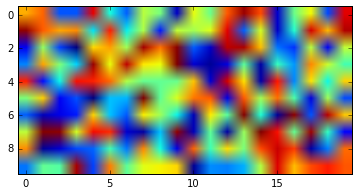

In [35]:
plt.imshow(X)

In [37]:
X.shape

(10, 20)

In [40]:
np.diag(S).shape

(10, 10)

In [43]:
X2 = np.dot(U[:,:2],np.dot(np.diag(S)[:2,:2],V[:2,:]))

In [44]:
X2

array([[ 0.6328992 ,  0.41167647,  0.20310819,  0.33864524,  0.51907468,
         0.53616971,  0.36376321,  0.81346363,  0.53236932,  0.39986649,
         0.61489747,  0.51963202,  0.73250652,  0.81071806,  0.65007179,
         0.50212511,  0.64144372,  0.40122613,  0.49326911,  0.78791095],
       [ 0.60045772,  0.661527  ,  0.50815876,  0.56048827,  0.69627865,
         0.75421962,  0.47323885,  0.66879814,  0.55658585,  0.73444072,
         0.40068842,  0.41975233,  0.56895443,  0.68790955,  0.62871804,
         0.6140127 ,  0.53989345,  0.74043784,  0.5849153 ,  0.68562381],
       [ 0.55993166,  0.52509625,  0.36700201,  0.44163221,  0.58024609,
         0.62014345,  0.39789886,  0.65853944,  0.50157388,  0.56459446,
         0.43553008,  0.4162333 ,  0.57323775,  0.66900477,  0.58223058,
         0.52595214,  0.52671669,  0.5685923 ,  0.50582896,  0.66031786],
       [ 0.4158555 ,  0.7219703 ,  0.65909051,  0.62107927,  0.68066386,
         0.7614157 ,  0.45249745,  0.36292744,  

In [34]:
np.dot(V,V.T)

array([[  1.00000000e+00,  -6.93889390e-18,  -1.13624388e-16,
         -5.55111512e-17,   6.93889390e-18,   0.00000000e+00,
         -4.85722573e-17,   1.38777878e-17,   1.38777878e-16,
          1.15359111e-16,  -7.11236625e-17,  -6.85215773e-17,
          2.77555756e-17,   3.12250226e-17,  -1.80411242e-16,
         -1.45716772e-16,  -7.63278329e-17,  -5.20417043e-17,
         -2.77555756e-17,   8.32667268e-17],
       [ -6.93889390e-18,   1.00000000e+00,  -3.92914867e-16,
          3.33066907e-16,  -2.91433544e-16,  -4.16333634e-17,
         -1.73472348e-16,   2.08166817e-17,   1.66533454e-16,
          3.72965547e-17,   5.46437895e-17,   2.25514052e-17,
          0.00000000e+00,   1.04083409e-17,  -1.49186219e-16,
         -3.46944695e-17,   2.08166817e-17,   4.16333634e-17,
          7.28583860e-17,  -2.77555756e-17],
       [ -1.13624388e-16,  -3.92914867e-16,   1.00000000e+00,
         -2.60208521e-17,   2.77122075e-16,   5.89805982e-17,
          3.56485674e-16,   3.20923843e-17

In [ ]:
# Here we define a function to tokenize and step each sentenc
import nltk
from nltk.stem.snowball import SnowballStemmer

class MyCorpus(object):
    def __init__(self,corpus,name,build_dict=False):
        self.name = name
        self.build_dict = build_dict
        self.path = os.path.join(model_saved,'gensim')
        self.path_txt = os.path.join(self.path,name+'.txt')
        self._write_clean_file(corpus)
        self.path_dict = os.path.join(self.path,name+'.dict')
        self.stopwords = nltk.corpus.stopwords.words('english')
        self.stemmer = SnowballStemmer("english")
        self.load_dictionary()

    def _write_clean_file(self,corpus):
        with open(self.path_txt,'w+') as f:
            for elt in corpus:
                f.write(elt+'\n')
        
    def build_dictionary(self):
        print 'We are building the dictionary - wait a second'
        dictionary = corpora.Dictionary(self.tokenize_and_stem(line) for line in open(self.path_txt))
        # Remove very rare term
        dictionary.filter_extremes(no_below=25,no_above=0.85,keep_n=200000)
        dictionary.compactify()
        dictionary.save(self.path_dict)      
        
    def load_dictionary(self):
        if not os.path.isfile(self.path_dict) or self.build_dict:
            self.build_dictionary()
        setattr(self,'dictionary',corpora.Dictionary.load(self.path_dict))
                
    def tokenize_and_stem(self,text):
        tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        filtered_tokens = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token.lower())
        filtered_tokens = [token for token in filtered_tokens if token not in stopwords]
        stems = map(stemmer.stem,filtered_tokens)
        return map(str,stems)

    def __iter__(self):
        
        for line in open(self.path_txt):
            # assume there's one document per line, tokens separated by whitespace
            yield self.dictionary.doc2bow(self.tokenize_and_stem(line))
            

## Application: Identify a list of potential collaborators 

In [31]:
def idx_to_collaborators(index, n_neightboor = 20, based_on ='abstracts', verbose =0):
    ''' Return a list of potential collaborator for the corresponding index
    
    Args:
        index : index of the contribution to look at.
        n_neightboor : Number of recommendations to consider.
        based_on : Base the recommendation on the abstract or the titles ?
        verbose : Degree of verbosity for the return.
        
    Returns:
        A list of potential authors that work in similar topic.
        
    '''
    recom = idx_to_recom(index, n_neightboor , based_on,verbose)
    auths = [f.strip() for f in reduce(lambda x,y:x+','+y,list(recom.authors)).split(',')]
    return auths